C:\Users\sreep\AppData\Local\Temp\ipykernel_49976\3745768405.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=device)


✅ Loaded EfficientNet-B3 model from: C:\Users\sreep\OneDrive\Desktop\Food based\.venv\best_food_classifier_b3.pth

🍽️ Predicted Food Type: takoyaki


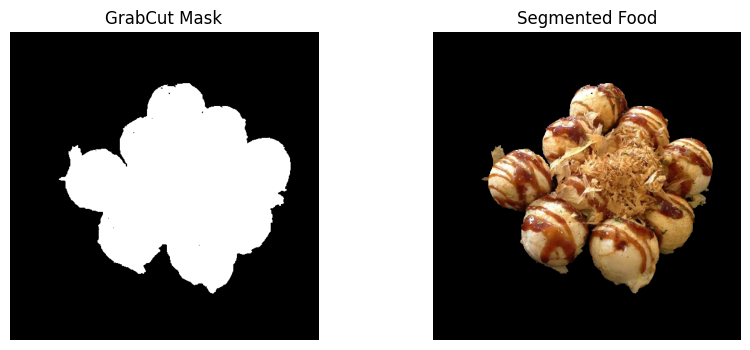

🧩 Foreground pixels (food area): 79513

🔍 Searching USDA for: takoyaki
⚠️ Retrying with fallback term: 'takoyaki'


ValueError: No USDA entry found for 'takoyaki'.

In [9]:
# ------------------------------------------------------------
# 🍞 FOOD CLASSIFICATION + PIXEL-BASED CALORIE ESTIMATION
# Using Trained EfficientNet-B3 + GrabCut + USDA API
# ------------------------------------------------------------

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# ============================================================
# CONFIGURATION
# ============================================================
IMAGE_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\.venv\images\takoyaki\3855074.jpg"
MODEL_PATH = r"C:\Users\sreep\OneDrive\Desktop\Food based\.venv\best_food_classifier_b3.pth"
CLASS_FILE = r"C:\Users\sreep\OneDrive\Desktop\Food based\data\food-101\meta\classes.txt"
API_KEY = "3MAZSbznBwb08neomhHMnSDTqZLBdiJzImKO9d6e"  # 🔑 Replace with your USDA key
CALORIE_SCALING_FACTOR = 1e-4  # adjust empirically if needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# STEP 0 — LOAD TRAINED MODEL
# ============================================================

# Load class names
with open(CLASS_FILE, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
num_classes = len(class_names)

# Create same model structure used during training (EfficientNet-B3)
def create_model(num_classes):
    model = models.efficientnet_b3(weights=None)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# Load trained weights safely
model = create_model(num_classes).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
try:
    model.load_state_dict(state_dict)
    print(f"✅ Loaded EfficientNet-B3 model from: {MODEL_PATH}")
except RuntimeError:
    print("⚠️ Classifier mismatch — loading backbone only...")
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier.1")}
    model.load_state_dict(filtered_state_dict, strict=False)
    print("✅ Backbone loaded successfully.")

model.eval()

# Preprocessing (EfficientNet-B3 expects 300×300 input)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ============================================================
# STEP 1 — CLASSIFY THE FOOD IMAGE
# ============================================================
img_pil = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = transform(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_label = class_names[predicted_idx.item()]

print(f"\n🍽️ Predicted Food Type: {predicted_label}")

# ============================================================
# STEP 2 — SEGMENT IMAGE USING GRABCUT
# ============================================================
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
rect = (15, 15, w - 35, h - 35)
mask = np.zeros((h, w), np.uint8)
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

cv2.grabCut(img, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
segmented = img_rgb * mask2[:, :, np.newaxis]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("GrabCut Mask")
plt.imshow(mask2, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmented Food")
plt.imshow(segmented)
plt.axis("off")
plt.show()

# ============================================================
# STEP 3 — CALCULATE FOOD PIXEL AREA
# ============================================================
food_pixels = np.count_nonzero(mask2)
print(f"🧩 Foreground pixels (food area): {food_pixels}")

# ============================================================
# STEP 4 — FETCH CALORIE DATA FROM USDA
# ============================================================
def search_usda_food(food_name, api_key):
    """Search USDA database for a food and return the first entry."""
    url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {"api_key": api_key, "query": food_name, "pageSize": 1}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    if "foods" not in data or not data["foods"]:
        raise ValueError(f"No USDA entry found for '{food_name}'.")
    return data["foods"][0]

def get_kcal_per_100g(food_entry):
    """Extract kcal per 100g from USDA entry."""
    for n in food_entry.get("foodNutrients", []):
        if "energy" in n.get("nutrientName", "").lower() and "kcal" in n.get("unitName", "").lower():
            return n["value"]
    raise ValueError("No energy (kcal) info found in USDA entry.")

# Query USDA (replace underscores)
query_name = predicted_label.replace("_", " ")
print(f"\n🔍 Searching USDA for: {query_name}")

try:
    entry = search_usda_food(query_name, API_KEY)
except ValueError:
    alt_name = predicted_label.split("_")[0]
    print(f"⚠️ Retrying with fallback term: '{alt_name}'")
    entry = search_usda_food(alt_name, API_KEY)

desc = entry.get("description", "No description")
kcal_per_100g = get_kcal_per_100g(entry)

print(f"✅ Found: {desc}")
print(f"🔥 Energy: {kcal_per_100g:.2f} kcal / 100g")

# ============================================================
# STEP 5 — CALORIE ESTIMATION
# ============================================================
estimated_calories = food_pixels * CALORIE_SCALING_FACTOR * (kcal_per_100g / 100)

print("\n========================")
print("📊 CALORIE ESTIMATION REPORT")
print("========================")
print(f"🍽️ Predicted Food: {predicted_label}")
print(f"🧩 Food pixel count: {food_pixels}")
print(f"🔥 Calories per 100g (USDA): {kcal_per_100g:.2f}")
print(f"⚙️ Scaling factor: {CALORIE_SCALING_FACTOR}")
print(f"🍰 Estimated total calories: {estimated_calories:.2f} kcal")

# ============================================================
# STEP 6 — SAVE MASKED OUTPUT
# ============================================================
output_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]
output_path = f"segmented_{predicted_label}_{output_name}.png"
cv2.imwrite(output_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
print(f"\n✅ Masked image saved as: {output_path}")
